In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


In [6]:
# Downloading historical stock prices for Lockheed Martin (LMT)
df = yf.download('LMT', start='2015-01-01', end='2024-04-01')

# Keeping only 'Close' prices
df = df[['Close']]
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,LMT
Date,
2015-01-02,146.789383
2015-01-05,143.736816
2015-01-06,143.060959
2015-01-07,144.906143
2015-01-08,148.171402


In [7]:
#Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)


In [8]:
#Preparing the data for time-series approach
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(df_scaled, time_steps)

# Splitting into training & testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [9]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0364 - val_loss: 0.0018
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011 - val_l

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


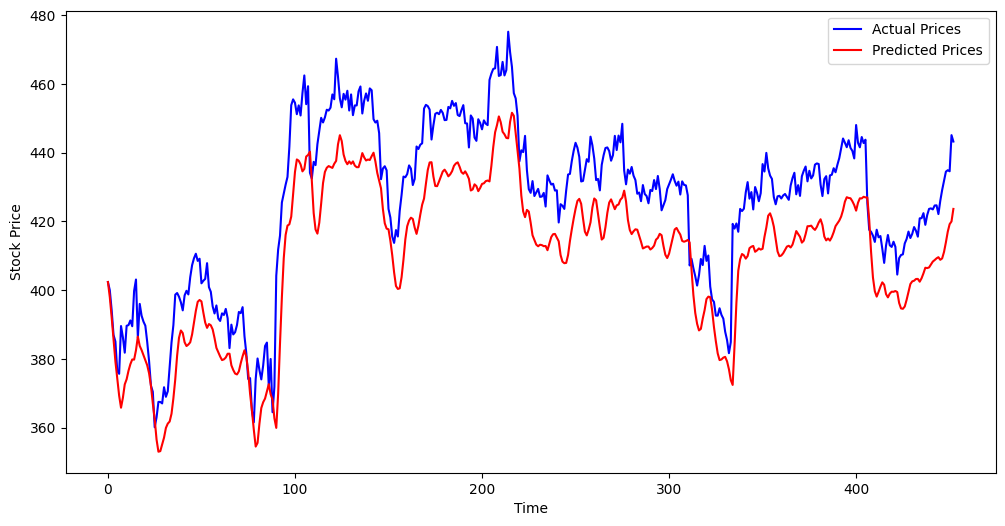

In [10]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
